In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import Spectral

import nitime.algorithms as tsa

## Content
1. [Sine function](#Sine-function)
2. [Summation of sine waves](#Summation-of-sine-waves)
3. [AR(n) model](#AR-model)
4. [Fractional Brownian motion](#Fractional-Brownian-motion)
5. [SOI](#SOI)

## Sine function

First let's do an ideal test with a sine function signal $X(t) = \sin(2\pi f t)$ with $f=0.02$ so that the period should be $1/f = 50$

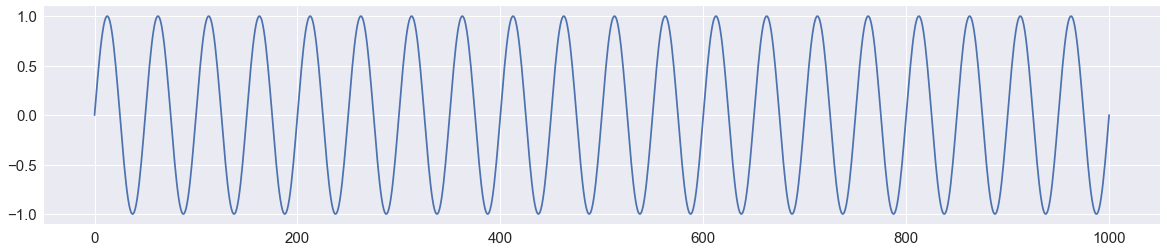

In [2]:
to = np.arange(1001)
f = 0.02
Xo = np.sin(2*np.pi*f*to)

sns.set(style="darkgrid", font_scale=1.5)
plt.subplots(figsize=[20, 4])
plt.plot(to, Xo)  # plot the original time seires

In [4]:
# parameters setup

tau = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points
dcon = 1/(8*np.pi**2);  # the delay constant
dcon = dcon/1e3
%time wwa, phase, AR1_q, coi, freqs = Spectral.wwz(Xo, to, tau, c=dcon, nMC=0, nproc=8, standardize=False, detrending=False)
print(np.size(tau), np.size(freqs))

CPU times: user 3.16 s, sys: 69.8 ms, total: 3.23 s
Wall time: 4.1 s
101 475


0.99886785483


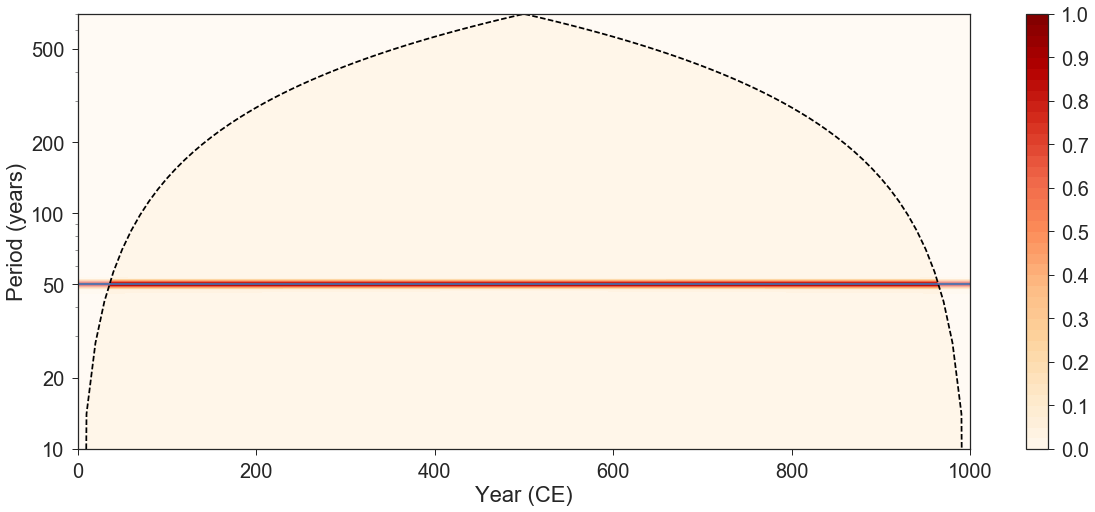

In [5]:
freq_ticks = [10, 20, 50, 100, 200, 500]

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 1, 41), tick_range=np.linspace(0, 1, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )
plt.plot(tau, 1/np.full(np.size(tau),f))
print(np.max(wwa))
#fig.savefig('./sin_wave.pdf')  # one can save the figure like this

0.4995004995
0.49966271158


0.49950049555
0.500472564159
499.340933241 498.716026694 447.019890013
0.4995004995
0.49966271158
0.49950049555


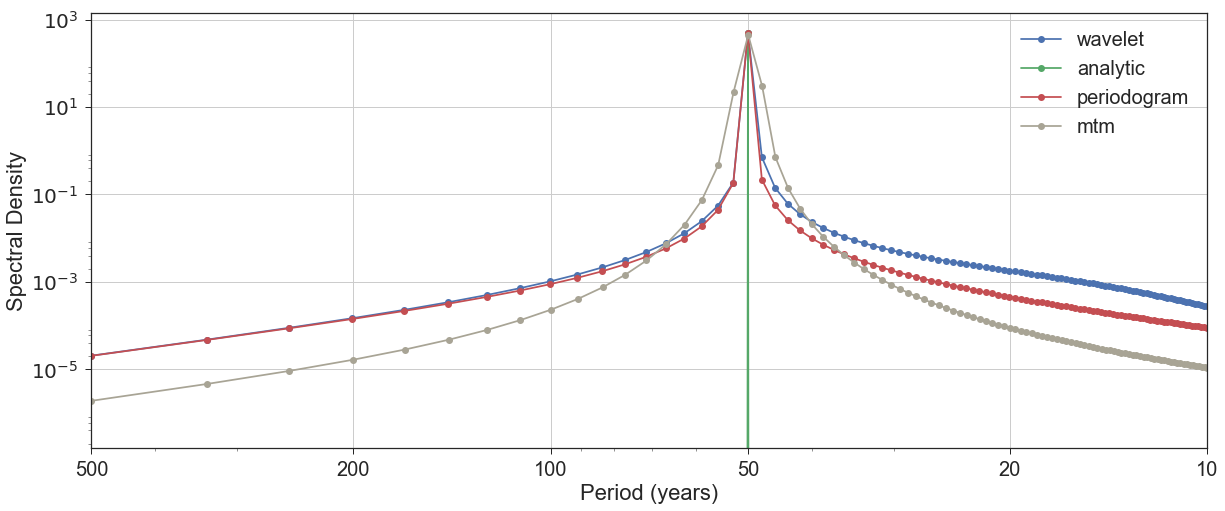

In [7]:
from scipy import signal
import scipy.stats.distributions as dist

# psd from wavelet       
psd = Spectral.wwa2psd(wwa, to, freqs, tau, c=dcon, anti_alias=False)

fig = Spectral.plot_psd(psd, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                        label='wavelet',
                        lmstyle='-o',
                       )

nf = np.size(freqs)
psd_sin = np.copy(freqs)
for k in range(nf):
    if np.abs(1/freqs[k] - 50) < 0.5:
        psd_sin[k] = 500
    else:
        psd_sin[k] = 0

# analytic
plt.plot(1/freqs, psd_sin, '-o', label='analytic')

# periodogram
freq, Pxx_den = signal.periodogram(Xo, 1)
plt.plot(1/freq[1:], Pxx_den[1:], '-o', label='periodogram')
integral = np.trapz(Pxx_den, freq)
print(integral)

# multi-taper method
freq_mtm, psd_mt, nu = tsa.multi_taper_psd(Xo, adaptive=False, jackknife=False, NW=1, Fs=1)
plt.plot(1/freq_mtm[1:], psd_mt[1:], '-o', label='mtm', color=sns.xkcd_rgb["greyish"])
integral = np.trapz(psd_mt, freq_mtm)
print(integral)
plt.legend(loc=1)

print(np.max(Pxx_den), np.max(psd), np.max(psd_mt))
#fig.savefig('./sin_wave_density.pdf')  # one can save the figure like this

print(np.var(Xo))
integral = np.trapz(psd, freqs)
print(integral)
integral = np.trapz(Pxx_den, freq)
print(integral)

## Summation of sine waves

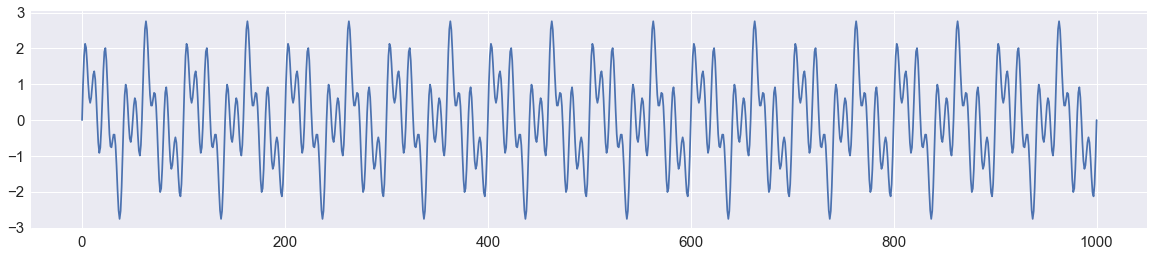

In [8]:
to = np.arange(1001)
f1, f2, f3 = 0.02, 0.05, 0.1
Xo = np.sin(2*np.pi*f1*to) + np.sin(2*np.pi*f2*to) + np.sin(2*np.pi*f3*to)

sns.set(style="darkgrid", font_scale=1.5)
plt.subplots(figsize=[20, 4])
plt.plot(to, Xo)  # plot the original time seires

In [9]:
# parameters setup

tau = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points
#freqs = np.linspace(1/500, 1/5, 100)  # frequencies
dcon = 1/(8*np.pi**2);  # the delay constant
dcon = dcon/1e3

%time wwa, phase, AR1_q, coi, freqs = Spectral.wwz(Xo, to, tau, c=dcon, nMC=0, nproc=8, standardize=False, detrending=False)
print(np.size(tau), np.size(freqs))

CPU times: user 3.18 s, sys: 23.2 ms, total: 3.2 s
Wall time: 3.99 s
101 475


1.0001580544


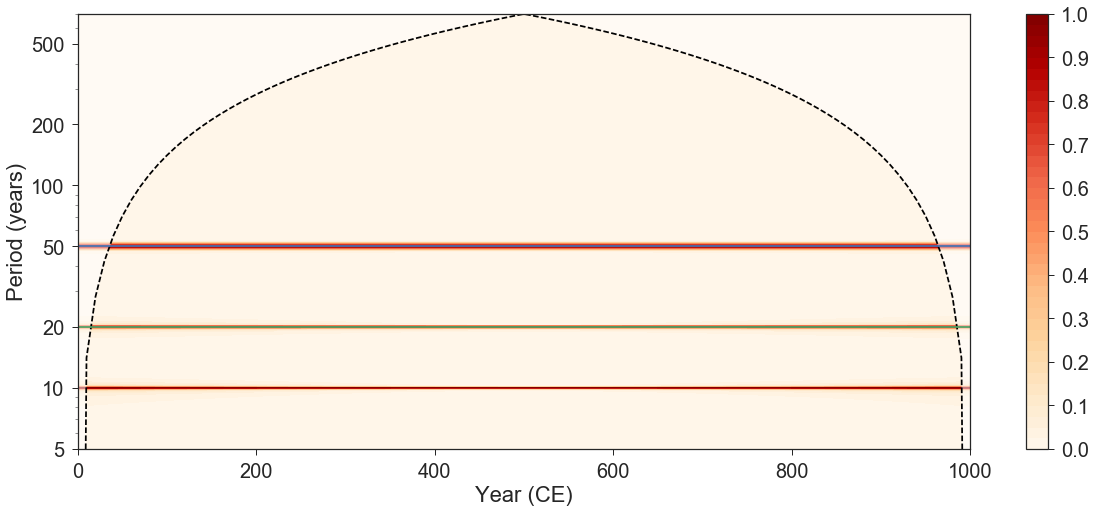

In [10]:
freq_ticks = [5, 10, 20, 50, 100, 200, 500]

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 1, 41), tick_range=np.linspace(0, 1, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )
plt.plot(tau, 1/np.full(np.size(tau),f1))
plt.plot(tau, 1/np.full(np.size(tau),f2))
print(np.max(wwa))

500.686844178 500.006017342 447.317037292
1.4985014985
1.49850120074
1.49867424591
1.50126307103


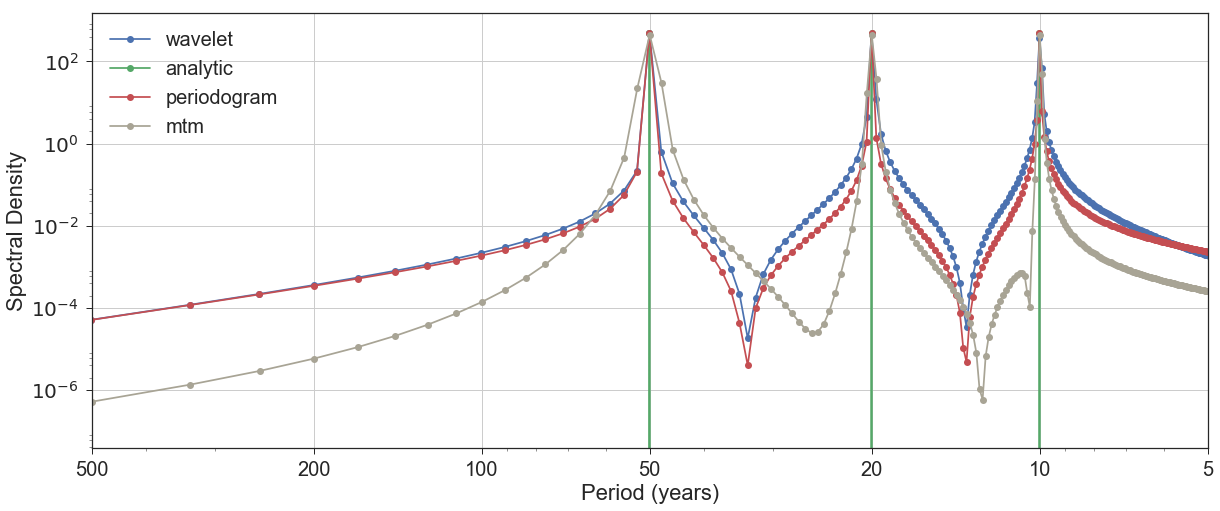

In [18]:
psd = Spectral.wwa2psd(wwa, to, freqs, tau, c=dcon, anti_alias=False)
from scipy import signal

# psd from wavelet        
fig = Spectral.plot_psd(psd, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                        label='wavelet',
                        lmstyle='-o',
                       )

nf = np.size(freqs)
psd_sin = np.copy(freqs)

for k in range(nf):
    if np.abs(1/freqs[k] - 50) < 5*1e-2 or np.abs(1/freqs[k] - 20) < 5*1e-2 or np.abs(1/freqs[k] - 10) < 1e-2:
        psd_sin[k] = 500
    else:
        psd_sin[k] = 0
        
# analytic        
plt.plot(1/freqs, psd_sin, '-o', label='analytic')

# periodogram
freq, Pxx_den = signal.periodogram(Xo, 1)
plt.plot(1/freq[1:], Pxx_den[1:], '-o', label='periodogram')

# multi-taper method
freq_mtm, psd_mt, nu = tsa.multi_taper_psd(Xo, adaptive=False, jackknife=False, NW=1, Fs=1)
plt.plot(1/freq_mtm[1:], psd_mt[1:], '-o', label='mtm', color=sns.xkcd_rgb["greyish"])

plt.legend(loc=2)
print(np.max(Pxx_den), np.max(psd), np.max(psd_mt))

#fig.savefig('./psd.pdf')  # one can save the figure like this
print(np.var(Xo))
print(np.trapz(Pxx_den, freq))
print(np.trapz(psd, freqs))
print(np.trapz(psd_mt, freq_mtm))

## AR model

The autoregressive moving-average (ARMA) model for a random process $x[n]$:
$$ x[n] = \sum_{k=1}^{p}a_k x[n-k] + \sum_{k=0}^{q} b_k w[n-k],$$
where
$w[n]$ is white noise with zero mean and variance $\sigma_w^2$.
If all the $a_k$s are zero, $x[n]$ is called a MA linear random process;
if all the $b_k$s are zero, except or $b_0$, then $x[n]$ is called an AR linear random process.

If we take all the $b_k$s be zero except $b_0 = 1$, then we have an AR model:
$$ x[n] = \sum_{k=1}^{p}a_k x[n-k] + w[n],$$
whose power spectrum is given by
$$ S(f) = \frac{\sigma_w^2}{|1-\sum_{k=1}^p a_k e^{-i2\pi k f/f_s}|^2}, $$ 
where
$f_s$ is the sampling frequency.

References:
1. https://www.wikiwand.com/en/Autoregressive%E2%80%93moving-average_model
2. https://www.wikiwand.com/en/Autoregressive_model


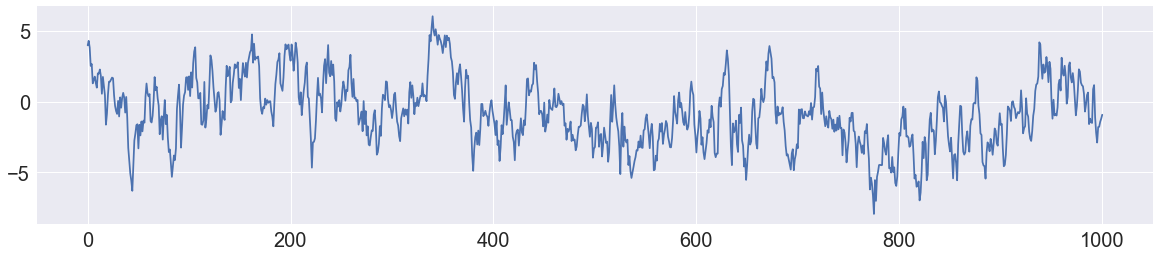

In [19]:
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(2333)

ar = np.array([.9])
ma = np.array([0])

arparams = np.r_[1, -ar]  # add zero-lag and negate
maparams = np.r_[1, ma]  # add zero-lag

to = np.arange(1001)
nobs = np.size(to)
Xo = arma_generate_sample(arparams, maparams, nobs, burnin=50, sigma=1)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to, Xo)

In [21]:
# parameters setup for WWZ

tau = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points
dcon = 1/(8*np.pi**2);  # the delay constant
dcon = dcon/1e3
%time wwa, phase, AR1_q, coi, freqs = Spectral.wwz(Xo, to, tau, c=dcon, nMC=0, nproc=8, standardize=False, detrending=False)
print(np.size(tau), np.size(freqs))

CPU times: user 3.18 s, sys: 18.1 ms, total: 3.19 s
Wall time: 3.86 s
101 475


/Users/Juno/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: There are outliers in the input amplitudes, and the `levels` have been set so that the outpliers will be ignored! One might want to use `Spectral.plot_wwadist(wwa)` to plot the distribution of the amplitudes with the 95% quantile line to check if the levels are appropriate.


1.54618079024


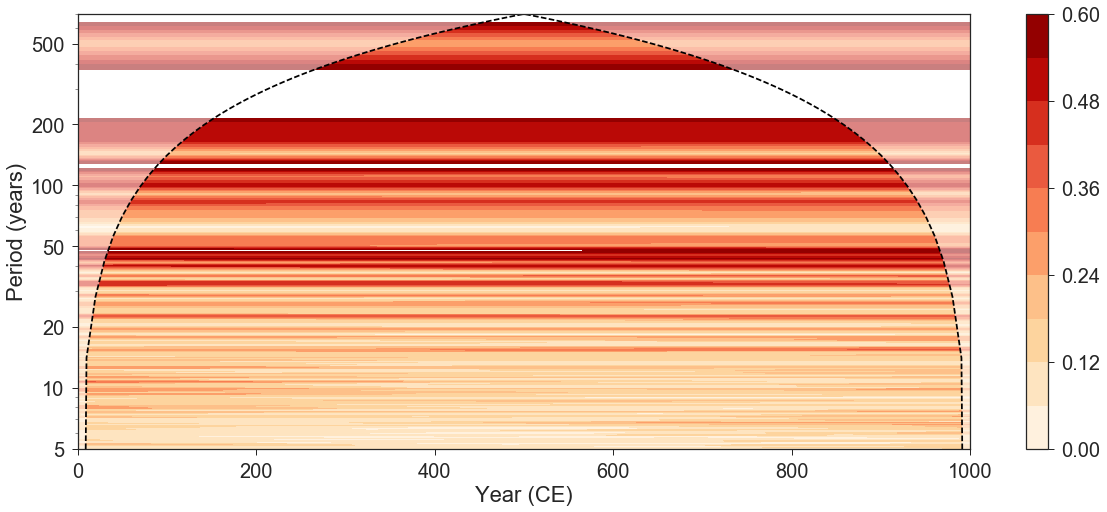

In [23]:
freq_ticks = [5, 10, 20, 50, 100, 200, 500]

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        #levels=np.linspace(0, 1, 41), tick_range=np.linspace(0, 1, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )

print(np.max(wwa))

Var of obs: 5.38596845693
Int of per: 5.3855229068
Int of wwz: 4.73490190105
Int of mtm: 5.12901817873


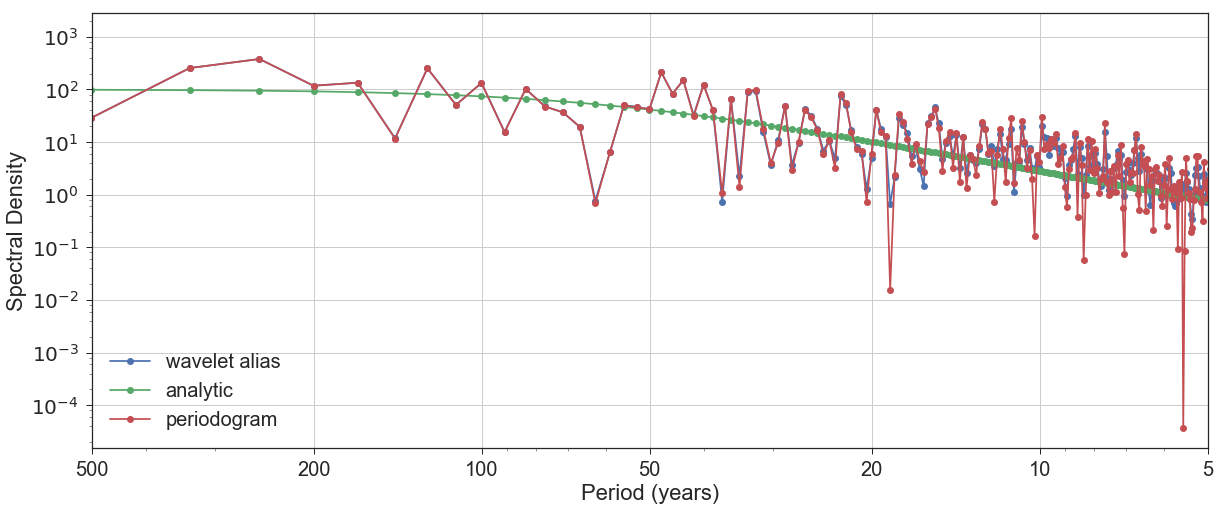

In [31]:
psd_evenly = Spectral.wwa2psd(wwa, to, freqs, tau, c=dcon, anti_alias=False)
#psd_antialias = Spectral.wwa2psd(wwa, to, fs, tau, c=dcon, weighted=True, anti_alias=True)

from scipy import signal

# psd from wavelet
fig = Spectral.plot_psd(psd_evenly, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                        label='wavelet alias',
                        lmstyle='-o',
                       )

psd_ar = Spectral.psd_ar(1, freqs, ar, 1)

# analytic
plt.plot(1/freqs, psd_ar, '-o', label='analytic')

# anti-alias
#plt.plot(1/fs, psd_antialias, '-o', label='wavelet antialias')

# periodogram
freq_evenly, Pxx_den_evenly = signal.periodogram(Xo, 1)
plt.plot(1/freq_evenly[1:], Pxx_den_evenly[1:], '-o', label='periodogram')

# multi-taper method
freq_mtm, psd_mt, nu = tsa.multi_taper_psd(Xo, adaptive=False, jackknife=False, NW=1, Fs=1)
#plt.plot(1/freq_mtm, psd_mt, '-o', label='mtm', color=sns.xkcd_rgb["greyish"])

plt.legend(loc=3)
#fig.savefig('./ar1.pdf')  # one can save the figure like this
print('Var of obs:', np.var(Xo))
print('Int of per:', np.trapz(Pxx_den_evenly, freq_evenly))
print('Int of wwz:', np.trapz(psd_evenly, freqs))
print('Int of mtm:', np.trapz(psd_mt, freq_mtm))

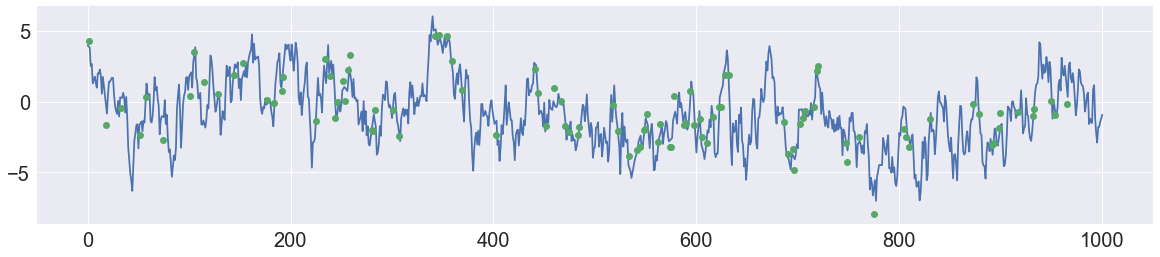

In [32]:
# generate some points to be deleted

import random
random.seed(2333)
n_del = 100
deleted_idx = random.sample(range(np.size(to)), n_del)

to_unevenly =  np.delete(to, deleted_idx)
Xo_unevenly =  np.delete(Xo, deleted_idx)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_unevenly, Xo_unevenly)  # plot the unevenly sampled time seires
plt.plot(to[deleted_idx], Xo[deleted_idx], 'o')  # plot the deleted points

In [35]:
# parameters setup for WWZ

tau = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points
dcon = 1/(8*np.pi**2);  # the delay constant
dcon = dcon/1e3
%time wwa, phase, AR1_q, coi, freqs = Spectral.wwz(Xo_unevenly, to_unevenly, tau, c=dcon, nMC=0, nproc=8, standardize=False, detrending=False)
print(np.size(tau), np.size(freqs))

CPU times: user 2.84 s, sys: 17.1 ms, total: 2.86 s
Wall time: 3.5 s
101 427


/Users/Juno/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: There are outliers in the input amplitudes, and the `levels` have been set so that the outpliers will be ignored! One might want to use `Spectral.plot_wwadist(wwa)` to plot the distribution of the amplitudes with the 95% quantile line to check if the levels are appropriate.


1.55850773598


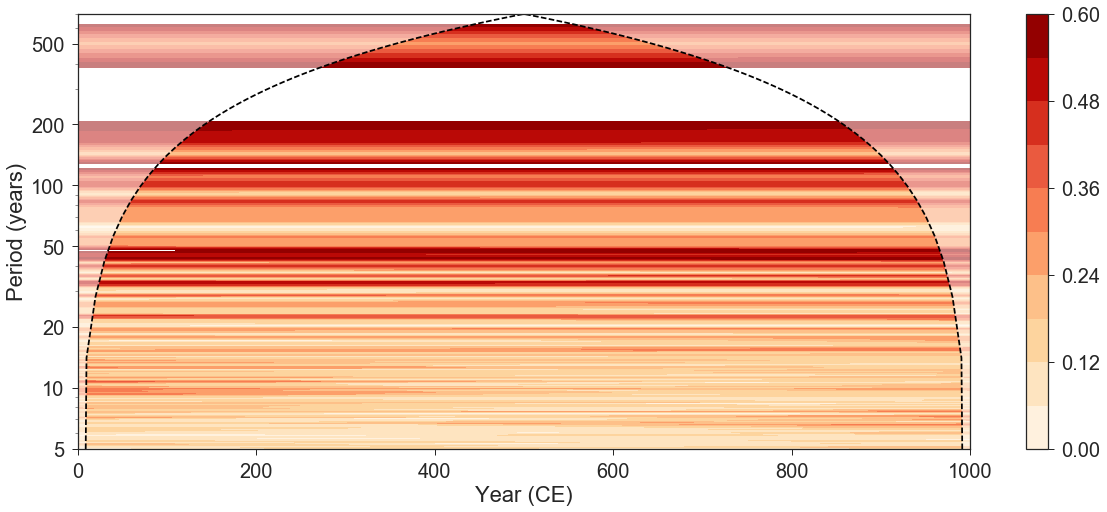

In [36]:
freq_ticks = [5, 10, 20, 50, 100, 200, 500]

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        #levels=np.linspace(0, 1, 41), tick_range=np.linspace(0, 1, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )

print(np.max(wwa))

Var of obs: 5.38596845693
Int of per: 5.43212345965
Int of wwz_alias: 5.22280690102
Int of mtm: 5.12901817873
Int of wwz_antialias: 4.72423747747


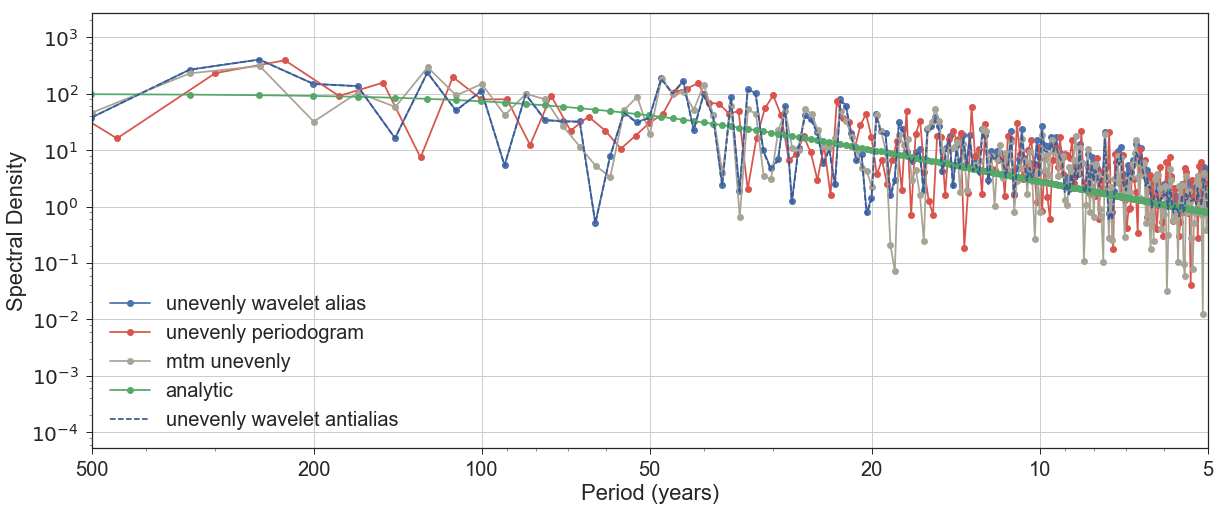

In [42]:
psd_unevenly = Spectral.wwa2psd(wwa, to_unevenly, freqs, tau, c=dcon, anti_alias=False)
psd_antialias = Spectral.wwa2psd(wwa, to_unevenly, freqs, tau, c=dcon, anti_alias=True)

from scipy import signal

# psd from wavelet unevenly
fig = Spectral.plot_psd(psd_unevenly, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                        label='unevenly wavelet alias',
                        lmstyle='-o',
                       )

psd_ar = Spectral.psd_ar(1, freqs, ar, 1)

# psd from wavelet evenly
#plt.plot(1/fs, psd_evenly, '--', label='evenly wavelet', color=sns.xkcd_rgb["denim blue"])

# periodogram unevenly
freq_unevenly, Pxx_den_unevenly = signal.periodogram(Xo_unevenly, 1)
plt.plot(1/freq_unevenly[1:], Pxx_den_unevenly[1:], '-o', label='unevenly periodogram', color=sns.xkcd_rgb["pale red"])
# periodogram evenly
#plt.plot(1/freq_evenly, Pxx_den_evenly, '--', label='evenly periodogram', color=sns.xkcd_rgb["pale red"])

# multi-taper method unevenly
freq_mtm_unevenly, psd_mt_unevenly, nu = tsa.multi_taper_psd(Xo, adaptive=False, jackknife=False, NW=1, Fs=1)
plt.plot(1/freq_mtm_unevenly[1:], psd_mt_unevenly[1:], '-o', label='mtm unevenly', color=sns.xkcd_rgb["greyish"])
# multi-taper method evenly
#plt.plot(1/freq_mtm, psd_mt, '--', label='mtm evenly', color=sns.xkcd_rgb["greyish"])

# analytic
plt.plot(1/freqs, psd_ar, '-o', label='analytic')

# anti-alias
plt.plot(1/freqs, psd_antialias, '--', label='unevenly wavelet antialias', color=sns.xkcd_rgb["denim blue"])

plt.legend(loc=3)
#fig.savefig('./ar1.pdf')  # one can save the figure like this
print('Var of obs:', np.var(Xo))
print('Int of per:', np.trapz(Pxx_den_unevenly, freq_unevenly))
print('Int of wwz_alias:', np.trapz(psd_unevenly, freqs))
print('Int of mtm:', np.trapz(psd_mt_unevenly, freq_mtm_unevenly))
print('Int of wwz_antialias:', np.trapz(psd_antialias, freqs))

## Fractional Brownian motion

References:
1. https://www.wikiwand.com/en/Fractional_Brownian_motion

CPU times: user 12.7 s, sys: 169 ms, total: 12.9 s
Wall time: 12.5 s


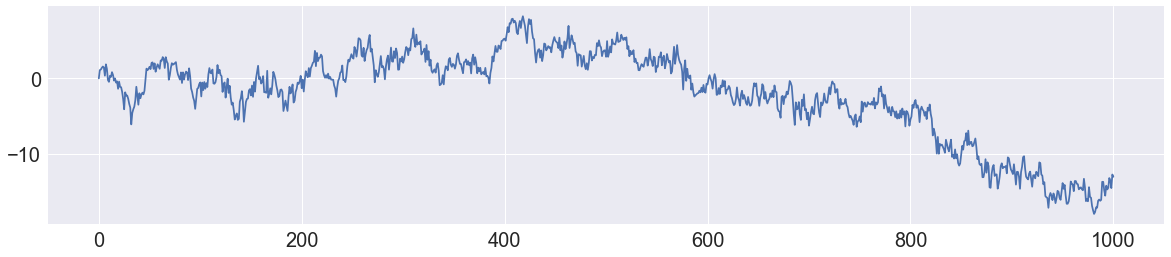

In [43]:
np.random.seed(2333)

H = 0.25
to = np.arange(1001)
%time Xo_BM = Spectral.fBMsim(N=np.size(to), H=H)
f = 0.02
Xo_har = np.sin(2*np.pi*f*to)
Xo = Xo_BM + Xo_har
sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to, Xo)

In [45]:
# parameters setup for WWZ
tau = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points
dcon = 1/(8*np.pi**2);  # the delay constant
dcon = dcon/1e3
%time wwa, phase, AR1_q, coi, freqs = Spectral.wwz(Xo, to, tau, c=dcon, nMC=0, nproc=8, standardize=False, detrending=False)
print(np.size(tau), np.size(freqs))

CPU times: user 3.16 s, sys: 19.1 ms, total: 3.17 s
Wall time: 3.88 s
101 475


/Users/Juno/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: There are outliers in the input amplitudes, and the `levels` have been set so that the outpliers will be ignored! One might want to use `Spectral.plot_wwadist(wwa)` to plot the distribution of the amplitudes with the 95% quantile line to check if the levels are appropriate.


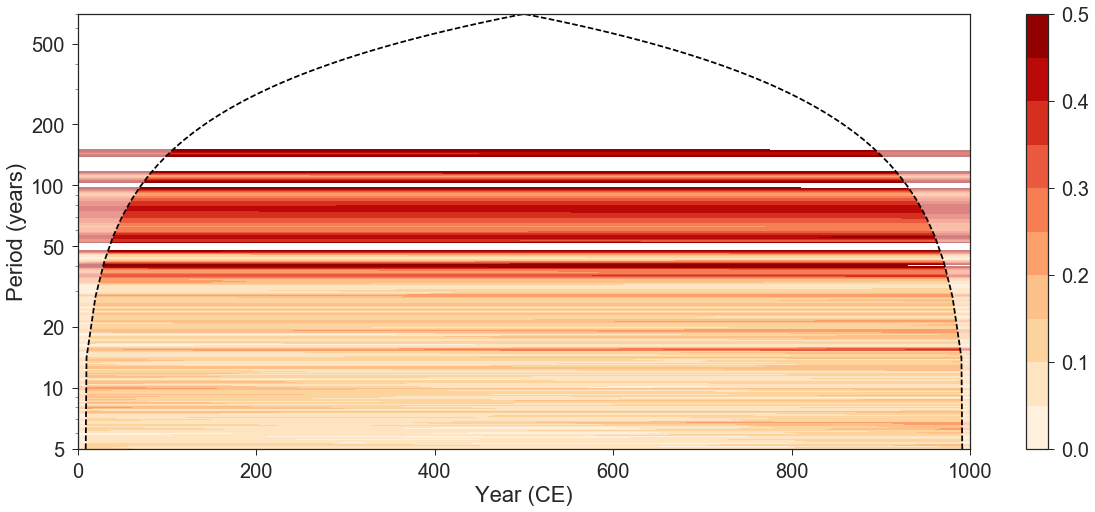

In [46]:
freq_ticks = [5, 10, 20, 50, 100, 200, 500]

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        #levels=np.linspace(0, 1, 41), tick_range=np.linspace(0, 1, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )

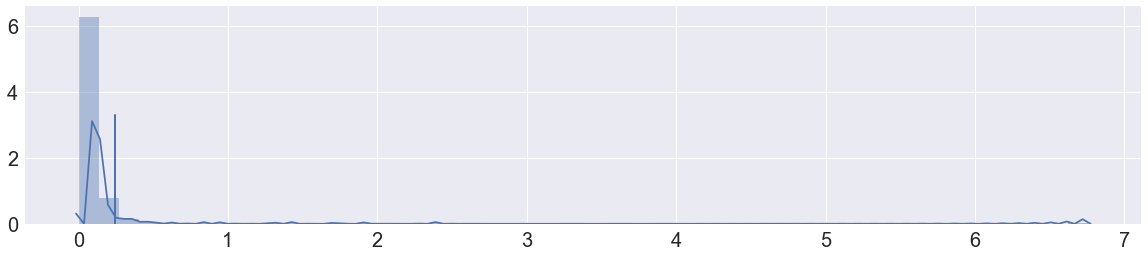

In [47]:
Spectral.plot_wwadist(wwa)

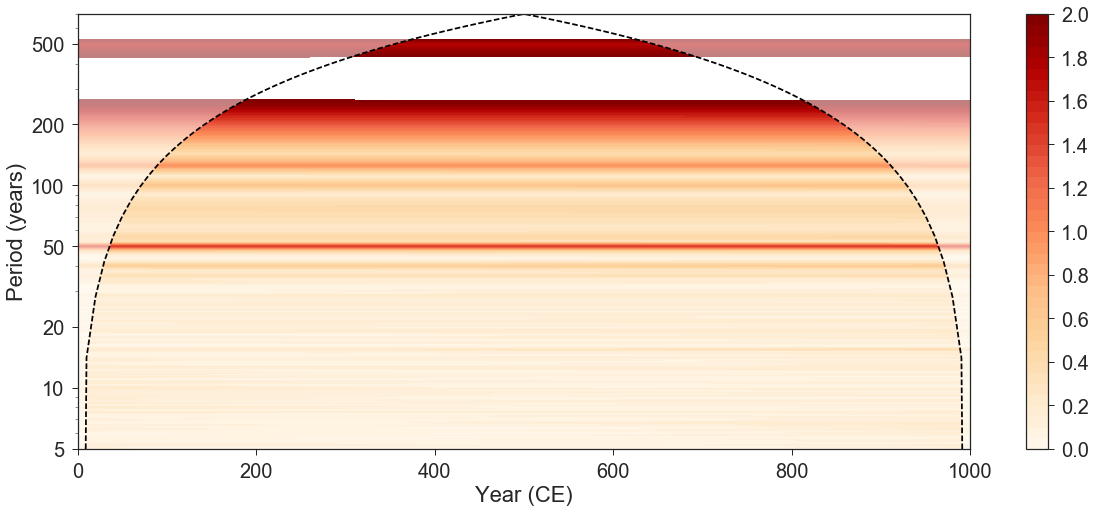

In [49]:
fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 2, 41), tick_range=np.linspace(0, 2, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )

Var of obs: 34.1584617416
Int of per: 34.1579441587
Int of wwz: 22.4908638076


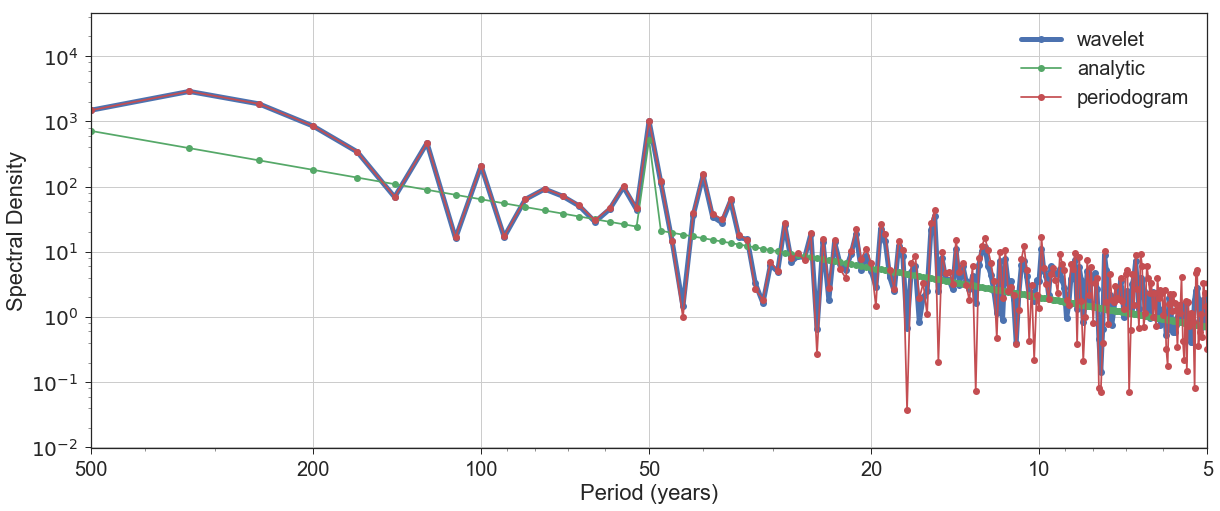

In [58]:
psd_evenly = Spectral.wwa2psd(wwa, to, freqs, tau, c=dcon, anti_alias=False)

wa = Spectral.WaveletAnalysis()
from scipy import signal
freq_evenly, Pxx_den_evenly = signal.periodogram(Xo, 1)
fig = Spectral.plot_psd(psd_evenly, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                        label='wavelet',
                        lmstyle='-o', linewidth=5,
                       )

psd_ana = Spectral.psd_fBM(freqs, to, H)

nf = np.size(freqs)
psd_sin = np.copy(freqs)

for k in range(nf):
    if np.abs(1/freqs[k] - 50) < 5*1e-2:
        psd_sin[k] = 500
    else:
        psd_sin[k] = 0
        
plt.plot(1/freqs, psd_ana+psd_sin, '-o', label='analytic')

plt.plot(1/freq_evenly[1:], Pxx_den_evenly[1:], '-o', label='periodogram')
plt.legend(loc=1)
print('Var of obs:', np.var(Xo))
print('Int of per:', np.trapz(Pxx_den_evenly, freq_evenly))
print('Int of wwz:', np.trapz(psd_evenly, freqs))

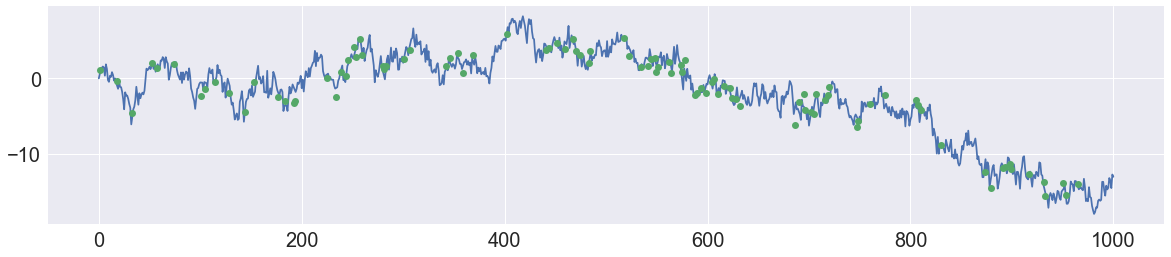

In [47]:
# generate some points to be deleted

import random
random.seed(2333)
n_del = 100
deleted_idx = random.sample(range(np.size(to)), n_del)

to_unevenly =  np.delete(to, deleted_idx)
Xo_unevenly =  np.delete(Xo, deleted_idx)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_unevenly, Xo_unevenly)  # plot the unevenly sampled time seires
plt.plot(to[deleted_idx], Xo[deleted_idx], 'o')  # plot the deleted points

In [48]:
# parameters setup for WWZ
tau = np.linspace(np.min(to), np.max(to), 101)  # evenly-spaced time points
fs = np.linspace(1/500, 1/5, 100)  # frequencies
dcon = 1/(8*np.pi**2);  # the delay constant

print(np.size(tau), np.size(fs))
%time wwa, phase, AR1_q, coi, fs = Spectral.wwz(Xo_unevenly, to_unevenly, tau, fs=fs, c=dcon/1000, nMC=0, nproc=8, standardize=False, detrending=False)

101 100
CPU times: user 1.08 s, sys: 7.74 ms, total: 1.09 s
Wall time: 1.43 s


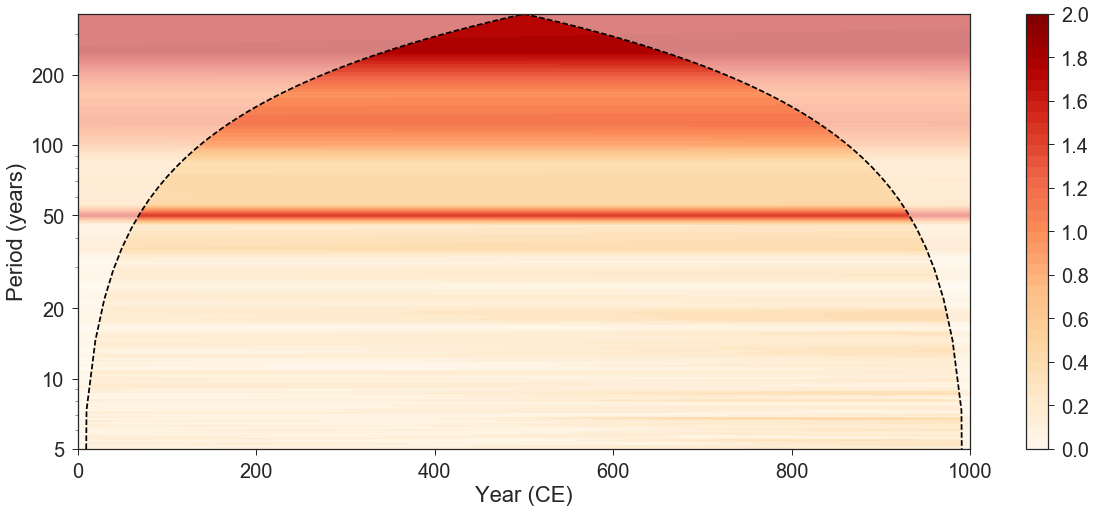

In [49]:
freq_ticks = [5, 10, 20, 50, 100, 200, 500]

fig = Spectral.plot_wwa(wwa, fs, tau, coi=coi, AR1_q=AR1_q,
                        levels=np.linspace(0, 2, 41), tick_range=np.linspace(0, 2, 11),
                        yticks=freq_ticks, ylim=[np.min(freq_ticks), np.max(coi)],
                        plot_cone=True, plot_signif=False,
                       )

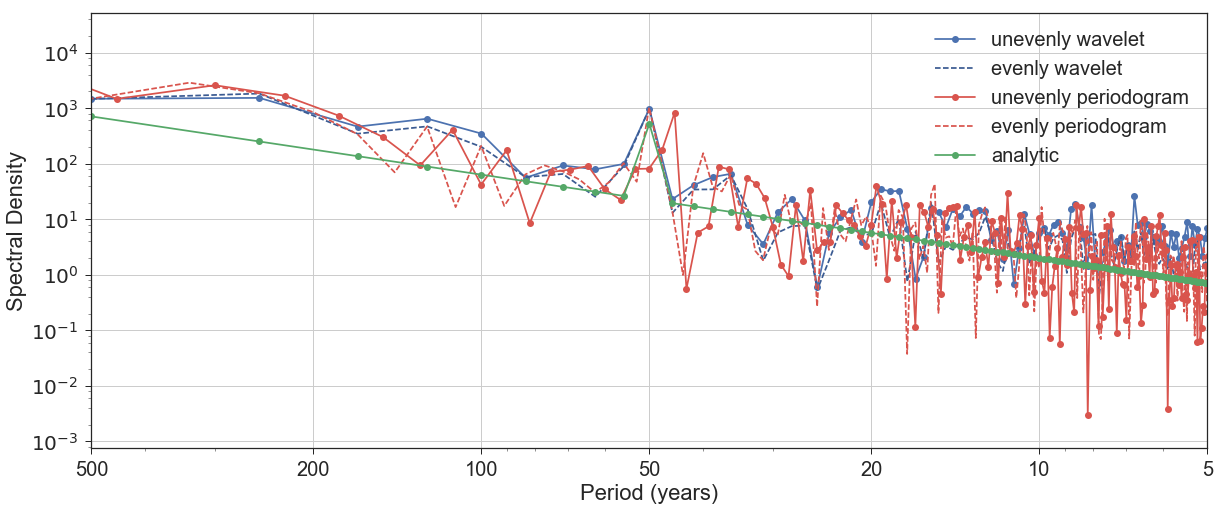

In [57]:
psd_unevenly = Spectral.wwa2psd(wwa, to_unevenly, fs, tau, c=dcon, weighted=True, anti_alias=True)

wa = Spectral.WaveletAnalysis()
from scipy import signal
freq_unevenly, Pxx_den_unevenly = signal.periodogram(Xo_unevenly, 1)
fig = Spectral.plot_psd(psd_unevenly, fs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                        label='unevenly wavelet',
                        lmstyle='-o',
                       )

psd_ana = Spectral.psd_fBM(fs, to, H)

nf = np.size(fs)
df = np.mean(np.diff(fs))
psd_sin = np.copy(fs)

for k in range(nf):
    if np.abs(1/fs[k] - 50) < 1e-3:
        psd_sin[k] = 1/df
    else:
        psd_sin[k] = 0
        
plt.plot(1/fs, psd_evenly, '--', label='evenly wavelet', color=sns.xkcd_rgb["denim blue"])

# freqs from periodogram function starts from 0, so we skip the first element
plt.plot(1/freq_unevenly[1:], Pxx_den_unevenly[1:], '-o', label='unevenly periodogram', color=sns.xkcd_rgb["pale red"])
plt.plot(1/freq_evenly[1:], Pxx_den_evenly[1:], '--', label='evenly periodogram', color=sns.xkcd_rgb["pale red"])
plt.plot(1/fs, psd_ana+psd_sin, '-o', label='analytic')

plt.legend(loc=0)

## SOI

In [110]:
import pandas as pd

data = pd.read_csv('./soi_data.csv')

796


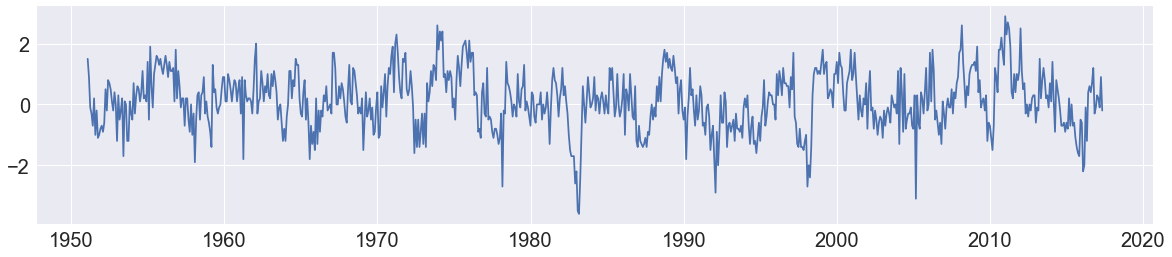

In [125]:
Xo_evenly = np.asarray(data['SOI'])
to_evenly = np.asarray(data['Year']) + np.asarray(data['Month'])/12

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_evenly, Xo_evenly)  # plot the original time seires
print(np.size(Xo_evenly))

In [82]:
# parameters setup

tau = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)  # evenly-spaced time point
wa = Spectral.WaveletAnalysis()

dcon = 1/(8*np.pi**2) # the delay constant
dcon = dcon/1e3
%time wwa, phase, AR1_q, coi, freqs = Spectral.wwz(Xo_evenly, to_evenly, tau, c=dcon, nMC=0, nproc=8, a_thres=10, standardize=False, detrending=False)
print(np.size(tau), np.size(freqs))

CPU times: user 2.54 s, sys: 17.8 ms, total: 2.56 s
Wall time: 3.1 s
101 377


/Users/Juno/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: There are outliers in the input amplitudes, and the `levels` have been set so that the outpliers will be ignored! One might want to use `Spectral.plot_wwadist(wwa)` to plot the distribution of the amplitudes with the 95% quantile line to check if the levels are appropriate.


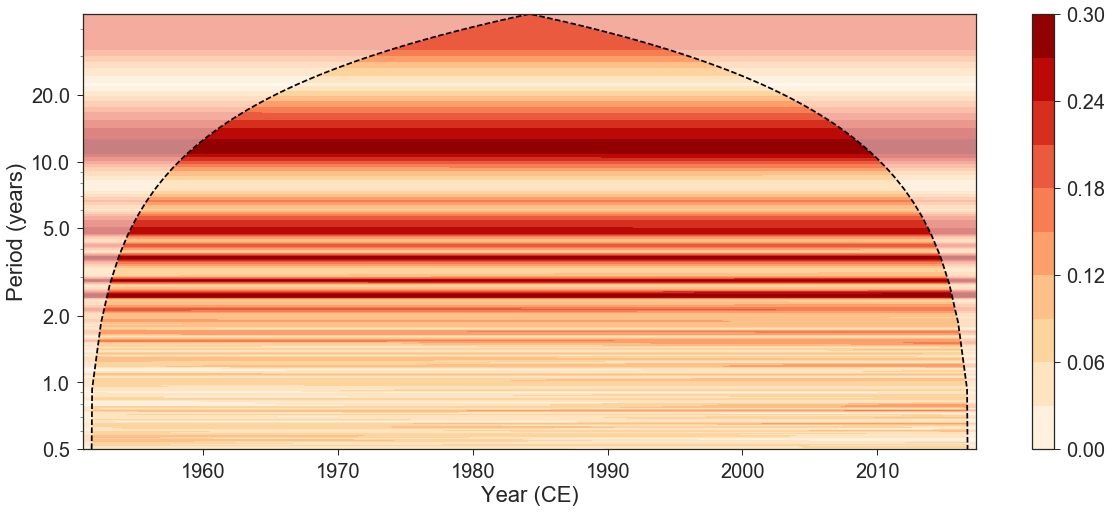

In [69]:
freq_ticks = [0.5, 1, 2, 5, 10, 20, 50]

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        #levels=np.linspace(0, 1, 11), tick_range=np.linspace(0, 1, 11),
                        ylim=[np.min(freq_ticks), np.max(coi)],
                        yticks=freq_ticks,
                        plot_cone=True, plot_signif=False,
                       )

#fig.savefig('./soi_test.pdf')  # one can save the figure like this

Var of obs: 34.1584617416
Int of per: 0.896445954648
Int of wwz_alias: 0.875863201504
Int of wwz_antialias: 0.65224188178


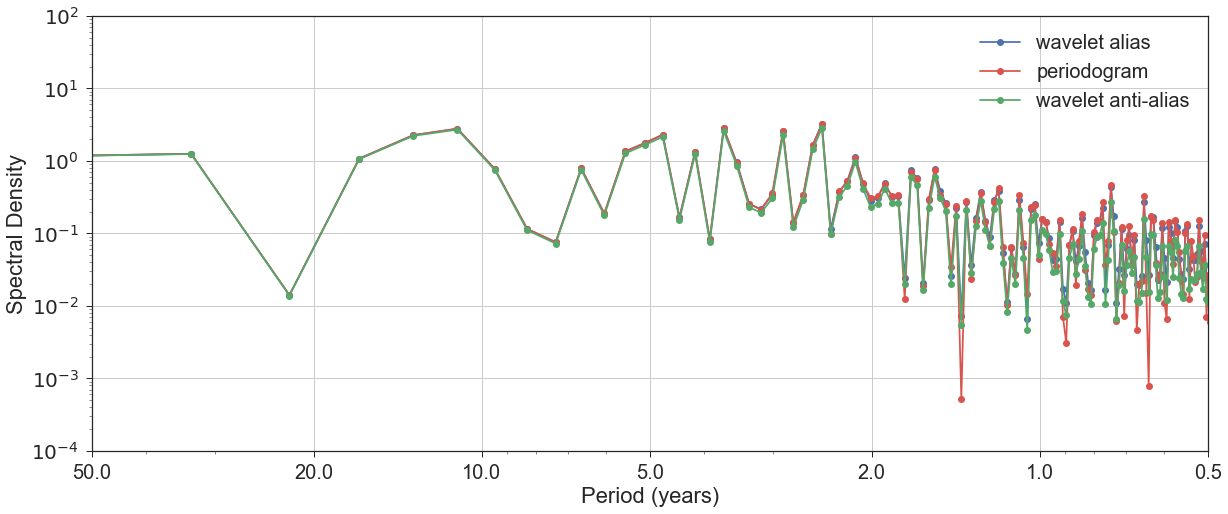

In [70]:
psd_evenly = Spectral.wwa2psd(wwa, to_evenly, freqs, tau, c=dcon, anti_alias=False)
psd_antialias = Spectral.wwa2psd(wwa, to_evenly, freqs, tau, c=dcon, anti_alias=True)

wa = Spectral.WaveletAnalysis()
from scipy import signal
freq_evenly, Pxx_den_evenly = signal.periodogram(Xo_evenly, 12)
#print(freq)
fig = Spectral.plot_psd(psd_evenly, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)], ylim=[1e-4,1e2],
                        label='wavelet alias',
                        lmstyle='-o',
                       )

plt.plot(1/freq_evenly[1:], Pxx_den_evenly[1:], '-o', label='periodogram', color=sns.xkcd_rgb["pale red"])
plt.plot(1/freqs, psd_antialias, '-o', label='wavelet anti-alias')
plt.legend(loc=1)
print('Var of obs:', np.var(Xo))
print('Int of per:', np.trapz(Pxx_den_evenly, freq_evenly))
print('Int of wwz_alias:', np.trapz(psd_evenly, freqs))
print('Int of wwz_antialias:', np.trapz(psd_antialias, freqs))

696


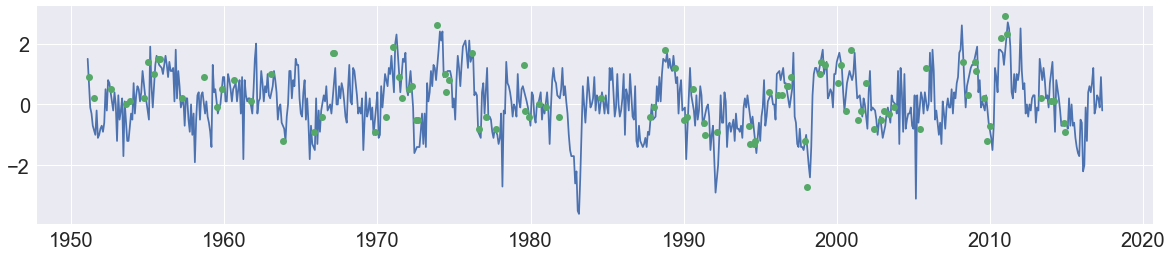

In [126]:
# generate some points to be deleted

import random
random.seed(2333)
n_del = 100
deleted_idx = random.sample(range(np.size(to_evenly)), n_del)

to_unevenly =  np.delete(to_evenly, deleted_idx)
Xo_unevenly =  np.delete(Xo_evenly, deleted_idx)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_unevenly, Xo_unevenly)  # plot the unevenly sampled time seires
plt.plot(to_evenly[deleted_idx], Xo_evenly[deleted_idx], 'o')  # plot the deleted points
print(np.size(Xo_unevenly))

In [127]:
# parameters setup

tau = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)  # evenly-spaced time points
dcon = 1/(8*np.pi**2);  # the delay constant
dcon = dcon/1e3
%time wwa, phase, AR1_q, coi, freqs = Spectral.wwz(Xo_unevenly, to_unevenly, tau, c=dcon, nMC=0, nproc=8, standardize=True, detrending=True)
print(np.size(tau), np.size(freqs))

CPU times: user 2.23 s, sys: 11.8 ms, total: 2.24 s
Wall time: 2.63 s
101 331


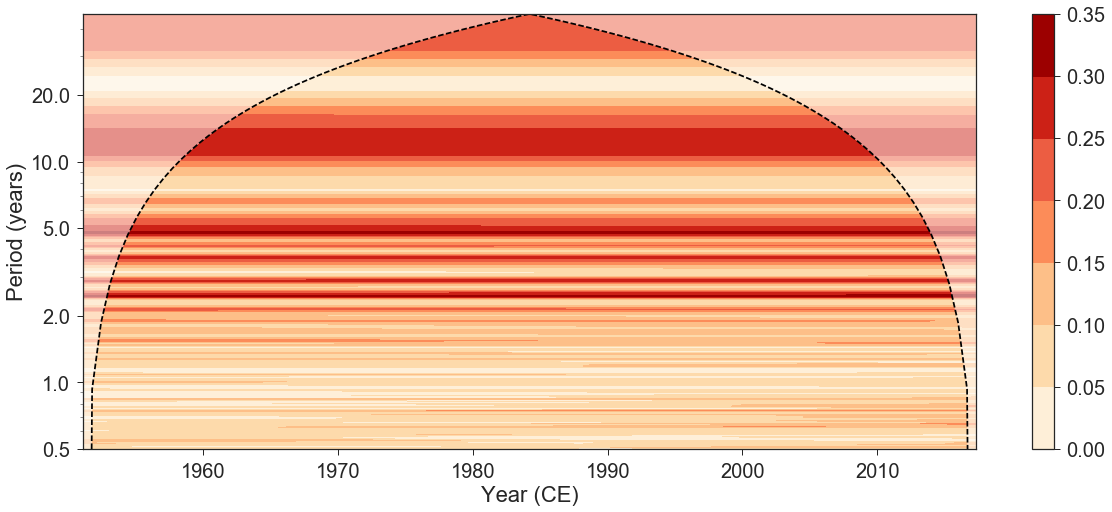

In [128]:
freq_ticks = [0.5, 1, 2, 5, 10, 20]

fig = Spectral.plot_wwa(wwa, freqs, tau, coi=coi, AR1_q=AR1_q,
                        #levels=np.linspace(0, 1, 11),
                        #tick_range=np.linspace(0, 1, 11),
                        ylim=[np.min(freq_ticks), np.max(coi)],
                        yticks=freq_ticks,
                        plot_cone=True, plot_signif=False,
                       )

Var of obs: 34.1584617416
Int of per: 0.88032955146
Int of wwz_alias: 0.656487506465


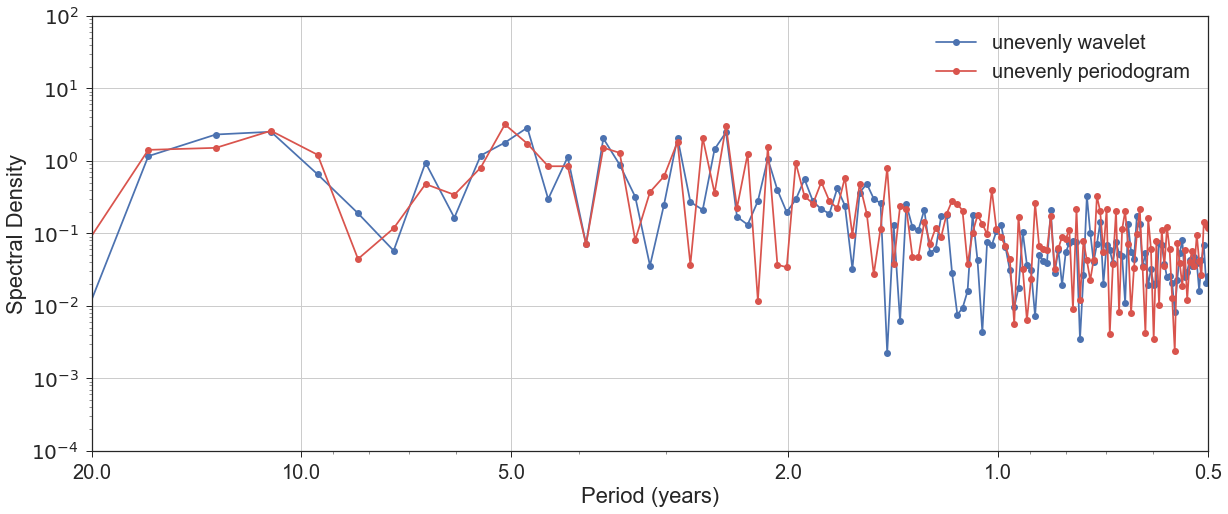

In [129]:
psd_unevenly = Spectral.wwa2psd(wwa, to_unevenly, freqs, tau, c=dcon)

wa = Spectral.WaveletAnalysis()

from scipy import signal
dt = np.mean(np.diff(to_unevenly))
fs = 1 / dt
freq_unevenly, Pxx_den_unevenly = signal.periodogram(Xo_unevenly, fs)
#print(freq)
fig = Spectral.plot_psd(psd_unevenly, freqs,
                        xticks=freq_ticks,
                        xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                        ylim=[1e-4,1e2],
                        label='unevenly wavelet',
                        lmstyle='-o',
                       )
#plt.plot(1/freqs, psd_evenly, '--', label='evenly wavelet', color=sns.xkcd_rgb["denim blue"])

plt.plot(1/freq_unevenly[1:], Pxx_den_unevenly[1:], '-o', label='unevenly periodogram', color=sns.xkcd_rgb["pale red"])

#plt.plot(1/freq_evenly[1:], Pxx_den_evenly[1:], '--', label='evenly periodogram', color=sns.xkcd_rgb["pale red"])

plt.legend(loc=0)
print('Var of obs:', np.var(Xo))
print('Int of per:', np.trapz(Pxx_den_unevenly, freq_unevenly))
print('Int of wwz_alias:', np.trapz(psd_unevenly, freqs))